# Preprocessing

In [1]:
import os
import sys
import pandas as pd
from copy import copy

data_path = os.path.join(os.getcwd(), '../data')

In [2]:
df = pd.read_csv(os.path.join(data_path, 'data_correct_label.csv'), index_col='Municipality')

In [3]:
df.head()

,territory__surface_area,territory__altitude,territory__longitude,territory__latitude,territory__geographic_indicators_utm_coordinates_x_utm_coordinates_x,territory__geographic_indicators_utm_coordinates_y_utm_coordinates_y,population_density_of_population_surface_area_surface_area,population_density_of_population_density_density,population_population_by_sex_total,population_population_by_age_groups_from_0_to_14_years,...,main_aggregates_gross_value_added_2019_hostelry,main_aggregates_gross_value_added_2019_financial_and_insurance_activities,main_aggregates_gross_value_added_2019_real_estate_technical_and_adm_activities,main_aggregates_gross_value_added_2019_public_administration_and_other_services,main_aggregates_gross_value_added_2019_total.2,quality_of_life_useful_surface_area_of_dwellings_up_to_60_m,economic_sectors_head_of_livestock_main,economic_sectors_cultivated_land_main,population_population_by_sex_main,culture_sports_facilities_main
Municipality,,,,,,,,,,,,,,,,,,,,,
Abella de la Conca,78.27,956.0,1.092892,42.162392,342450.0,4669650.0,78.27,2.2,171,16,...,NaN,NaN,NaN,NaN,NaN,NaN,avian,herbaceous_crops,men,pavilions
Abrera,19.94,105.0,1.903100,41.518531,408471.0,4596983.0,19.94,632.9,12620,2138,...,NaN,NaN,NaN,NaN,NaN,NaN,ovine,herbaceous_crops,men,other_facilities
Àger,160.57,642.0,0.762617,42.002881,314700.0,4652600.0,160.57,3.7,588,49,...,NaN,NaN,NaN,NaN,NaN,NaN,porcine,herbaceous_crops,men,other_facilities
Agramunt,79.65,337.0,1.099819,41.788086,342100.0,4628075.0,79.65,68.6,5464,834,...,NaN,NaN,NaN,NaN,NaN,NaN,avian,herbaceous_crops,men,other_facilities
Aguilar de Segarra,43.32,480.0,1.632131,41.740044,386250.0,4621900.0,43.32,6.6,286,56,...,NaN,NaN,NaN,NaN,NaN,NaN,porcine,herbaceous_crops,men,other_facilities


## Duplicated Columns

In [4]:
def getDuplicateColumns(df):
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

duplicated_columns = getDuplicateColumns(df)

In [5]:
df.drop(columns=duplicated_columns, inplace=True)

Most indicators are given as a population count, so such indicators need to be scaled to the municipality population in order to be comparable.

In [6]:
not_div_cols = list(df.filter(regex=r'catalan|density|education|per_capita|municipal_waste|^(?!.*surface).*territory.*$|(?=.*growth)(?=.*average)|turnout|rate').columns)

In [7]:
df['population_population_by_sex_total'].isna().sum()

0

In [8]:
not_div_cols.append('population_population_by_sex_total')
cols = df.loc[:, ~df.columns.isin(not_div_cols)].select_dtypes(include='number').columns
df[cols] = df.loc[:, ~df.columns.isin(not_div_cols)].select_dtypes(include='number').div(df['population_population_by_sex_total'], axis=0)

## Numerical Missing Values

In [9]:
percent_missing = df.isnull().sum() / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns, 'percent_missing': percent_missing}).reset_index(drop=True).iloc[1:, :]
missing_value_df_copy = copy(missing_value_df)
missing_value_df.describe()

,percent_missing
count,201.000000
mean,0.244832
std,0.360808
min,0.000000
25%,0.000000
50%,0.000000
75%,0.521647
max,0.995776


In [10]:
missing_value_df.head()

,column_name,percent_missing
1,territory__altitude,0.0
2,territory__longitude,0.0
3,territory__latitude,0.0
4,territory__geographic_indicators_utm_coordinat...,0.0
5,territory__geographic_indicators_utm_coordinat...,0.0


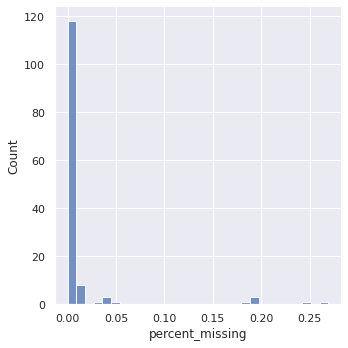

In [11]:
import seaborn as sns

missing_value_df = missing_value_df_copy[missing_value_df_copy['percent_missing'] < 0.3]

sns.set_theme()
sns.displot(missing_value_df, x='percent_missing', bins=30)

In [12]:
# Filter main df by removing columns with too many missing values
print(df.shape)
filtered_columns = missing_value_df['column_name'].to_numpy()
df = df[filtered_columns]
print(df.shape)

(947, 202)
(947, 137)


In [13]:
# Store how many missing values has the row before imputation to check for later outliers
missing_track = df.apply(lambda x: x.isna().sum(), axis=1)
missing_track.describe()

count    947.000000
mean       1.630412
std        1.992758
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max       16.000000
dtype: float64

In [14]:
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

simple_imputer = SimpleImputer()
simple_data = copy(df.select_dtypes(include='number'))
simple_data[:] = simple_imputer.fit_transform(simple_data)

Check that the imputation does not modify the distributions of data:

In [15]:
from scipy.stats import ks_2samp

def check_distributions(df1, df2, printit=True, badcols=False):
    
    pvalue = 0
    n = 0
    bad_cols = []
    for col in df2.columns:
        ks = ks_2samp(df1[col].dropna(), df2[col])
        pvalue += ks.pvalue
        
        if ks.pvalue < 0.05: 
            n += 1 
            if printit: 
                bad_cols.append(col)
                print(col, df1[col].isna().sum())
    
    avg_pvalue = pvalue/len(df1.columns)
    if badcols:
        return bad_cols
    return avg_pvalue, n

check_distributions(df.select_dtypes(include='number'), simple_data, printit=False)

(0.9521090909452513, 6)

In [16]:
for k in range(1,10):
    knn_imputer = KNNImputer(n_neighbors=k, weights='distance')
    knn_data = copy(df.select_dtypes(include='number'))
    knn_data[:] = knn_imputer.fit_transform(knn_data)
    print(f'K: {k}', check_distributions(df.select_dtypes(include='number'), knn_data, printit=False))

K: 1 (0.976178393587024, 2)
K: 2 (0.9752872168821807, 2)
K: 3 (0.9746252268089125, 3)
K: 4 (0.9730098605837669, 3)
K: 5 (0.9725183914898391, 3)
K: 6 (0.9708125741311289, 3)
K: 7 (0.9704462883485516, 3)
K: 8 (0.9685023774563816, 3)
K: 9 (0.9685283987597041, 3)


In [17]:
# Best imputer
knn_imputer = KNNImputer(n_neighbors=2, weights='distance')
imputed_data = copy(df.select_dtypes(include='number'))
imputed_data[:] = knn_imputer.fit_transform(imputed_data)
bad_cols = check_distributions(df.select_dtypes(include='number'), imputed_data, badcols=True)

elections_municipal_elections_electors 186
quality_of_life_type_of_dwellings_secondary 236


In [18]:
df.loc[:, imputed_data.columns] = imputed_data
df.drop(columns=bad_cols, inplace=True)

## Categorical Missing Values

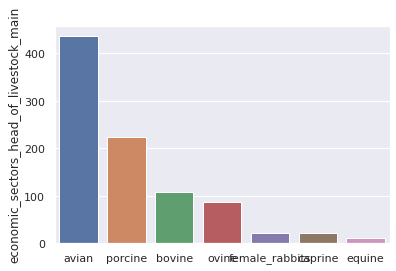

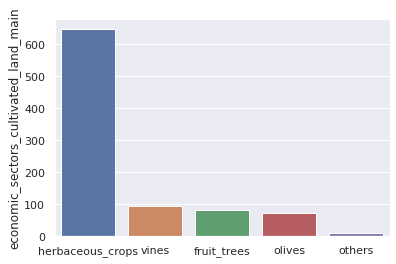

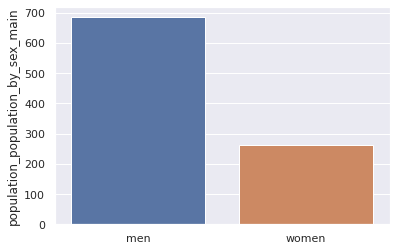

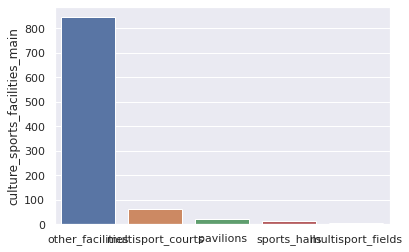

In [19]:
import matplotlib.pyplot as plt

for cat in df.select_dtypes(exclude='number').columns:
    aux = df[cat].value_counts()
    sns.barplot(x=aux.index, y=aux)
    plt.show()

In [20]:
df.select_dtypes(exclude='number').isna().sum()

economic_sectors_head_of_livestock_main    37
economic_sectors_cultivated_land_main      37
population_population_by_sex_main           0
culture_sports_facilities_main              0
dtype: int64

In [21]:
df = df.apply(lambda x: x.fillna('Unknown'))

In [22]:
df['missing_count'] = missing_track

## Outliers - Mahalanobis Distance

In [23]:
import numpy as np

num_df = copy(df.select_dtypes(include='number'))
covariance = np.cov(num_df, rowvar=False)
sum(sum(pd.isna(covariance))) # Issues with covariance due to high correlations

0

In [24]:
covariance_pm1 = np.linalg.matrix_power(covariance, -1)
centerpoint = np.mean(num_df, axis=0)

In [25]:
from scipy.stats import chi2
from scipy.spatial.distance import mahalanobis

distances = []
for i in range(len(num_df)):
      p1 = num_df.iloc[i,:]
      p2 = centerpoint
      # distance = mahalanobis(p1, p2, covariance_pm1)
      distance = (p1-p2).T.dot(covariance_pm1).dot(p1-p2)
      distances.append(distance)
distances = np.array(distances)

# Cutoff (threshold) value from Chi-Sqaure Distribution for detecting outliers 
cutoff = chi2.ppf(0.99, num_df.shape[1])

# # Index of outliers
outlierIndexes = np.where(distances > cutoff )

print('--- Index of Outliers ----')
print(len(outlierIndexes[0]))

--- Index of Outliers ----
198


## Model Based

In [26]:
from sklearn.ensemble import IsolationForest

num_df = copy(df.select_dtypes(include='number'))

#create the method instance
isf = IsolationForest(n_estimators = 100, random_state = 42, contamination = 'auto')

#use fit_predict on the data as we are using all the data
preds = isf.fit_predict(num_df)

# #extract outliers from the data
num_df["iso_forest_outliers"] = preds
num_df["iso_forest_outliers"] = num_df["iso_forest_outliers"].astype(str)

print(num_df.shape[1])

# #extract the scores from the data in terms of strength of outlier
num_df["iso_forest_scores"] = isf.decision_function(num_df.drop(columns='iso_forest_outliers')) #print how many outliers the data suggests
print(num_df["iso_forest_outliers"].value_counts())

133
1     919
-1     28
Name: iso_forest_outliers, dtype: int64


In [27]:
outlier_ix = num_df[num_df['iso_forest_outliers'] == '-1'].index
nonoutlier_ix = num_df[num_df['iso_forest_outliers'] == '1'].index
num_df.loc[outlier_ix, 'missing_count'].describe()

count    28.000000
mean      6.785714
std       4.003306
min       0.000000
25%       3.000000
50%       6.500000
75%      10.000000
max      15.000000
Name: missing_count, dtype: float64

In [28]:
num_df.loc[nonoutlier_ix, 'missing_count'].describe()

count    919.000000
mean       1.473341
std        1.668984
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max       16.000000
Name: missing_count, dtype: float64

In [29]:
clean_data = df.loc[nonoutlier_ix, :]
outlier_data = df.loc[outlier_ix, :]

clean_data.to_csv('../data/clean_data.csv')
outlier_data.to_csv('../data/outlier_data.csv')

---

## Categorical Label

The distribution of the label looks as follows:

In [30]:
import pandas as pd

df = pd.read_csv('../data/clean_data.csv')
label = df['culture_knowledge_of_catalan_speak'].to_frame()

In [31]:
label.describe()

,culture_knowledge_of_catalan_speak
count,919.000000
mean,0.797635
std,0.088523
min,0.267603
25%,0.748330
50%,0.813527
75%,0.859326
max,1.000000


<AxesSubplot:ylabel='Count'>

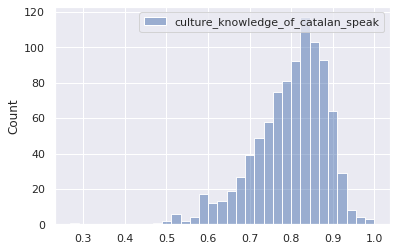

In [32]:
sns.histplot(label)

## Visualizations

In [33]:
import shapefile as shp
import matplotlib.pyplot as plt
import numpy as np

In [34]:
import pandas as pd
import seaborn as sns

df = pd.read_csv('../data/clean_data.csv', index_col='Municipality')
df.drop('missing_count', axis=1, inplace=True)

In [36]:
min_val = df['culture_knowledge_of_catalan_speak'].min()
max_val = df['culture_knowledge_of_catalan_speak'].max()

In [37]:
import matplotlib

norm = matplotlib.colors.Normalize(vmin=min_val, vmax=max_val)
cmap = matplotlib.cm.get_cmap('Spectral')

In [38]:
shp_path = '../plots/municipalities_map/divisions-administratives-v2r0-municipis-5000-20210701.shp'
sf = shp.Reader(shp_path)

In [39]:
sf.records()[1]

Record #1: ['080023', 'Aguilar de Segarra', 43.2198, '07', 'Bages', 'Manresa', '07', 'Catalunya Central', '*', '08', 'Barcelona', 'Barcelona']

In [60]:
def plot_map(sf, x_lim = None, y_lim = None, figsize = (16,12), data=None):
    '''
    Plot map with lim coordinates
    '''
    plt.figure(figsize = figsize)
    fig, ax = plt.subplots(figsize = figsize)
    
    # Values
    min_val = data['culture_knowledge_of_catalan_speak'].min()
    max_val = data['culture_knowledge_of_catalan_speak'].max()
    norm = matplotlib.colors.Normalize(vmin=min_val, vmax=max_val)
    cmap = matplotlib.cm.get_cmap('Spectral')
    
    id=0
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, 'k')
        
        try:
            # Fill
            record = sf.records()[id]
            gid = record[1]
            value = df.loc[gid, 'culture_knowledge_of_catalan_speak']
            rgba = cmap(norm(value))
            ax.fill(x, y, color=rgba)
            
            # shape_ex = sf.shape(id)
            # x_lon = np.zeros((len(shape_ex.points),1))
            # y_lat = np.zeros((len(shape_ex.points),1))
            # for ip in range(len(shape_ex.points)):
            #     x_lon[ip] = shape_ex.points[ip][0]
            #     y_lat[ip] = shape_ex.points[ip][1]
            # ax.fill(x_lon,y_lat, color)
        except:
            pass
        
        id = id+1
        
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)
    fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)

/tmp/ipykernel_4250/3708993636.py:43: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)


<Figure size 1152x864 with 0 Axes>

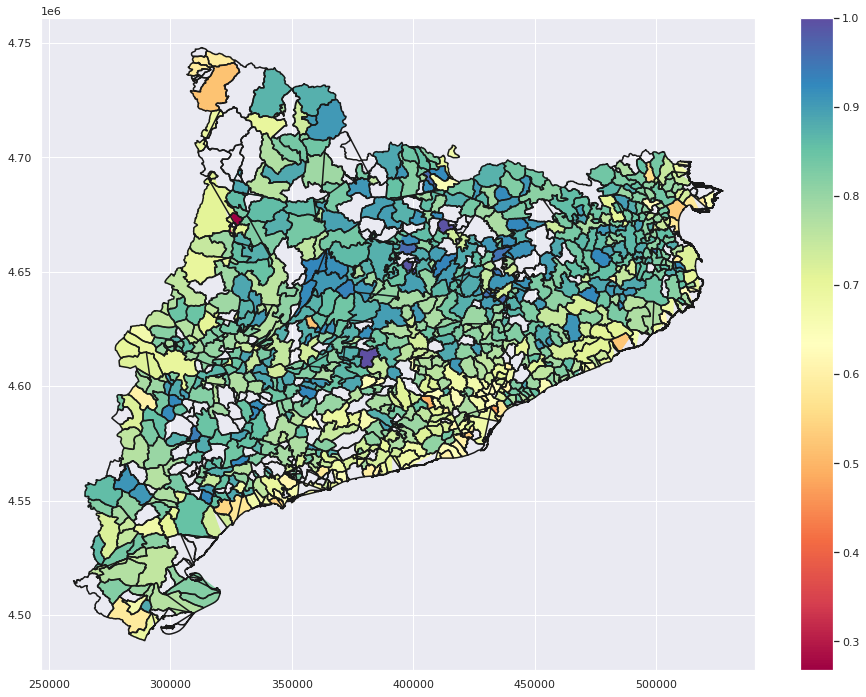

In [61]:
plot_map(sf, data=df)